<a href="https://colab.research.google.com/github/melataguia/regretion_cluster../blob/main/gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation de la bibliothèque xgboost

In [50]:
install.packages("xgboost")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("xgboost"):
“installation of package ‘xgboost’ had non-zero exit status”


# Charger les bibliothèques nécessaires

In [51]:
library(xgboost)
library(ggplot2)


# Charger les données

In [52]:
movies <- read.csv('../movies.csv')
ratings <- read.csv('../ratings.csv')
#tags <- read.csv('./tags.csv')

# Vérifier les données manquantes

In [53]:
missing_ratings <- colSums(is.na(ratings))
cat("Missing values in 'ratings':\n")
print(missing_ratings)

Missing values in 'ratings':
   userId   movieId    rating timestamp 
        0         0         0         6 


In [54]:
missing_movies <- colSums(is.na(movies))
cat("\nMissing values in 'movies':\n")
print(missing_movies)


Missing values in 'movies':
movieId   title  genres 
      0       0       0 


##Supprimer les lignes avec des valeurs manquantes dans le dataframe 'ratings'


In [55]:
ratings <- ratings[complete.cases(ratings), ]

##Supprimer les lignes avec des valeurs manquantes dans le dataframe 'movies'

In [56]:
movies <- na.omit(movies)

###Afficher le nombre de lignes après suppression des valeurs manquantes pour chaque dataframe


In [57]:
cat("Nombre de lignes après suppression des valeurs manquantes dans 'ratings':", nrow(ratings), "\n")
cat("Nombre de lignes après suppression des valeurs manquantes dans 'movies':", nrow(movies), "\n")

Nombre de lignes après suppression des valeurs manquantes dans 'ratings': 274089 
Nombre de lignes après suppression des valeurs manquantes dans 'movies': 9742 


# Fusion des données

In [58]:
data <- merge(ratings, movies, by = "movieId")

###Afficher les premières lignes de la dataframe 'data'

In [59]:
print(head(data))

  movieId userId rating  timestamp            title
1       1      1    4.0  964982703 Toy Story (1995)
2       1    232    3.5 1076955621 Toy Story (1995)
3       1    474    4.0  978575760 Toy Story (1995)
4       1    484    4.5 1342295949 Toy Story (1995)
5       1    304    5.0  881428344 Toy Story (1995)
6       1    471    5.0 1496671820 Toy Story (1995)
                                       genres
1 Adventure|Animation|Children|Comedy|Fantasy
2 Adventure|Animation|Children|Comedy|Fantasy
3 Adventure|Animation|Children|Comedy|Fantasy
4 Adventure|Animation|Children|Comedy|Fantasy
5 Adventure|Animation|Children|Comedy|Fantasy
6 Adventure|Animation|Children|Comedy|Fantasy


# Diviser les données en ensembles d'apprentissage et de test

In [60]:
set.seed(123)  # Pour la reproductibilité
train_indices <- sample(1:nrow(ratings), 0.8 * nrow(ratings))
train_data <- ratings[train_indices, ]
test_data <- ratings[-train_indices, ]

#Étape 1 : Prédire les recommandations en fonction de la moyenne des observations

In [75]:
# Définition des hyperparamètres
num_iterations <- 500
learning_rate <- 0.01

# Initialisation des prédictions sur l'ensemble d'entraînement et de test
train_data$prediction <- 0
test_data$prediction <- 0

In [76]:
mean_rating <- mean(train_data$rating)

# Étape 2 à 5 : Construction progressive du modèle avec XGBoost

In [77]:


for (i in 1:num_iterations) {
  # Étape 2 : Calcul des résidus
  train_data$residual <- train_data$rating - train_data$prediction

  # Étape 3 : Construction du modèle XGBoost pour prédire les résidus
  xgb_model <- xgboost(data = as.matrix(train_data[, c("userId", "movieId")]),
                       label = train_data$residual,
                       nrounds = 50,
                       eta = learning_rate)

  # Étape 4 : Mise à jour des prédictions sur l'ensemble d'entraînement
  train_data$prediction <- train_data$prediction + predict(xgb_model, as.matrix(train_data[, c("userId", "movieId")]))

  # Étape 5 : Mise à jour des prédictions sur l'ensemble de test
  test_data$prediction <- test_data$prediction + predict(xgb_model, as.matrix(test_data[, c("userId", "movieId")]))
}

# Moyenne des prédictions sur l'ensemble d'entraînement et de test
train_data$prediction <- mean_rating + train_data$prediction / num_iterations
test_data$prediction <- mean_rating + test_data$prediction / num_iterations

[1]	train-rmse:3.121569 
[2]	train-rmse:3.093627 
[3]	train-rmse:3.065993 
[4]	train-rmse:3.038665 
[5]	train-rmse:3.011640 
[6]	train-rmse:2.984916 
[7]	train-rmse:2.958418 
[8]	train-rmse:2.932285 
[9]	train-rmse:2.906372 
[10]	train-rmse:2.880816 
[11]	train-rmse:2.855477 
[12]	train-rmse:2.830491 
[13]	train-rmse:2.805716 
[14]	train-rmse:2.781286 
[15]	train-rmse:2.757068 
[16]	train-rmse:2.733123 
[17]	train-rmse:2.709420 
[18]	train-rmse:2.686013 
[19]	train-rmse:2.662873 
[20]	train-rmse:2.639965 
[21]	train-rmse:2.617401 
[22]	train-rmse:2.595042 
[23]	train-rmse:2.572936 
[24]	train-rmse:2.551076 
[25]	train-rmse:2.529445 
[26]	train-rmse:2.508132 
[27]	train-rmse:2.487023 
[28]	train-rmse:2.466121 
[29]	train-rmse:2.445536 
[30]	train-rmse:2.425109 
[31]	train-rmse:2.404997 
[32]	train-rmse:2.385053 
[33]	train-rmse:2.365417 
[34]	train-rmse:2.345954 
[35]	train-rmse:2.326690 
[36]	train-rmse:2.307734 
[37]	train-rmse:2.288918 
[38]	train-rmse:2.270397 
[39]	train-rmse:2.252


# Évaluation des performances du modèle en  utilisant l'erreur quadratique moyenne (RMSE)

In [72]:
rmse <- sqrt(mean((test_data$rating - test_data$prediction)^2))
cat("RMSE sur l'ensemble de test :", rmse, "\n")


RMSE sur l'ensemble de test : 1.108681 


In [73]:
# Calcul de la MAE
mae <- mean(abs(test_data$rating - test_data$prediction))

# Calcul de la Median Absolute Error
median_absolute_error <- median(abs(test_data$rating - test_data$prediction))

# Affichage des résultats
cat("MAE sur l'ensemble de test :", mae, "\n")
cat("Median Absolute Error sur l'ensemble de test :", median_absolute_error, "\n")


MAE sur l'ensemble de test : 0.8348253 
Median Absolute Error sur l'ensemble de test : 0.8399324 


## Calcul des erreurs absolues


In [66]:
test_data$error <- abs(test_data$rating - test_data$prediction)



# Construction de l'histogramme


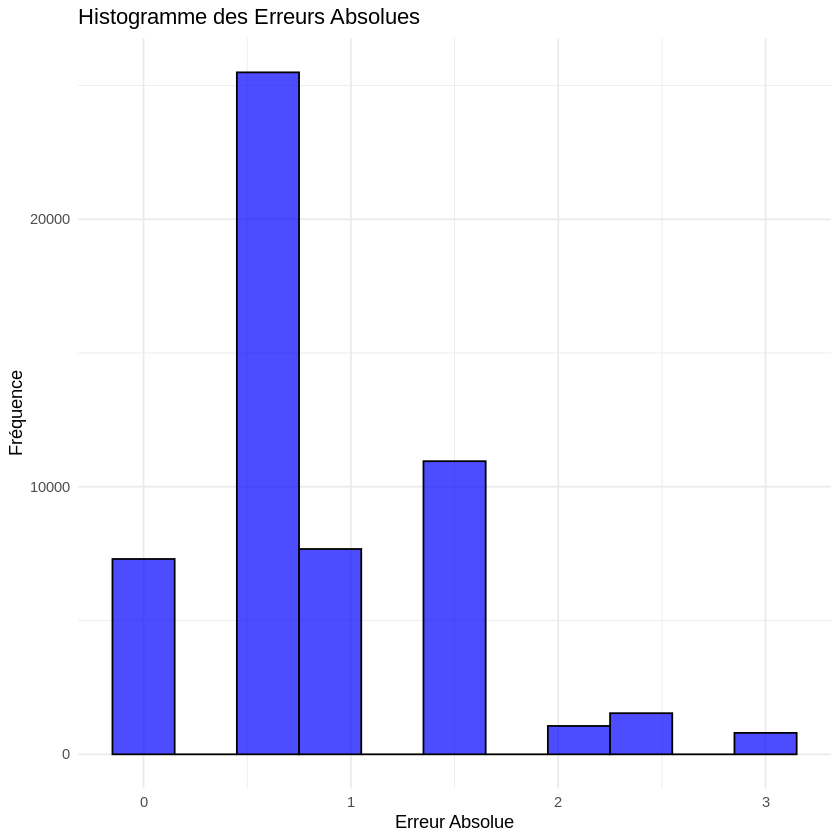

In [67]:
ggplot(test_data, aes(x = error)) +
  geom_histogram(binwidth = 0.3, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogramme des Erreurs Absolues",
       x = "Erreur Absolue",
       y = "Fréquence") +
  theme_minimal()

In [74]:
# Calcul de la somme des carrés des résidus
SS_res <- sum((test_data$rating - test_data$prediction)^2)

# Calcul de la somme totale des carrés
SS_tot <- sum((test_data$rating - mean(test_data$rating))^2)

# Calcul du coefficient de détermination R²
r_squared <- 1 - (SS_res / SS_tot)

# Affichage du résultat
cat("Coefficient de détermination R² sur l'ensemble de test :", r_squared, "\n")


Coefficient de détermination R² sur l'ensemble de test : -0.1281716 
